# ***Vehicles Detection Using CNN with MobileNet Fine Tuning Model***


# ***Importing modules and Loading datasets***

In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

# **Download from Google Drive**

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='Vehicles_Detection_dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Vehicles_Detection_dataset.zip')
!unzip Vehicles_Detection_dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: data/train/vehicles/3892.png  
 extracting: data/train/vehicles/3893.png  
 extracting: data/train/vehicles/3894.png  
 extracting: data/train/vehicles/3895.png  
  inflating: data/train/vehicles/3896.png  
 extracting: data/train/vehicles/3897.png  
 extracting: data/train/vehicles/3898.png  
 extracting: data/train/vehicles/3899.png  
 extracting: data/train/vehicles/39.png  
 extracting: data/train/vehicles/390.png  
 extracting: data/train/vehicles/3900.png  
  inflating: data/train/vehicles/3901.png  
 extracting: data/train/vehicles/3902.png  
 extracting: data/train/vehicles/3903.png  
 extracting: data/train/vehicles/3904.png  
 extracting: data/train/vehicles/3905.png  
 extracting: data/train/vehicles/3906.png  
  inflating: data/train/vehicles/3907.png  
 extracting: data/train/vehicles/3908.png  
  inflating: data/train/vehicles/3909.png  
 extracting: data/train/vehicles/391.png  
 extracting: data/train/vehic

In [3]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
NO_CLASSES = 2

# **Data Augmentation**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define image data generator with augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.2,1.0],
    rescale = 1/255,
    fill_mode='nearest')

test_datagon = ImageDataGenerator(
    rescale = 1/255
)    

# generate batches of augmented data with labels
train_dataset = train_datagen.flow_from_directory(
    'data/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)
test_dataset = test_datagon.flow_from_directory(
    'data/test/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)
val_dataset = test_datagon.flow_from_directory(
    'data/validation/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

Found 12971 images belonging to 2 classes.
Found 2764 images belonging to 2 classes.
Found 2025 images belonging to 2 classes.


In [5]:
class_names = train_dataset.class_indices.keys()
class_names

dict_keys(['non-vehicles', 'vehicles'])

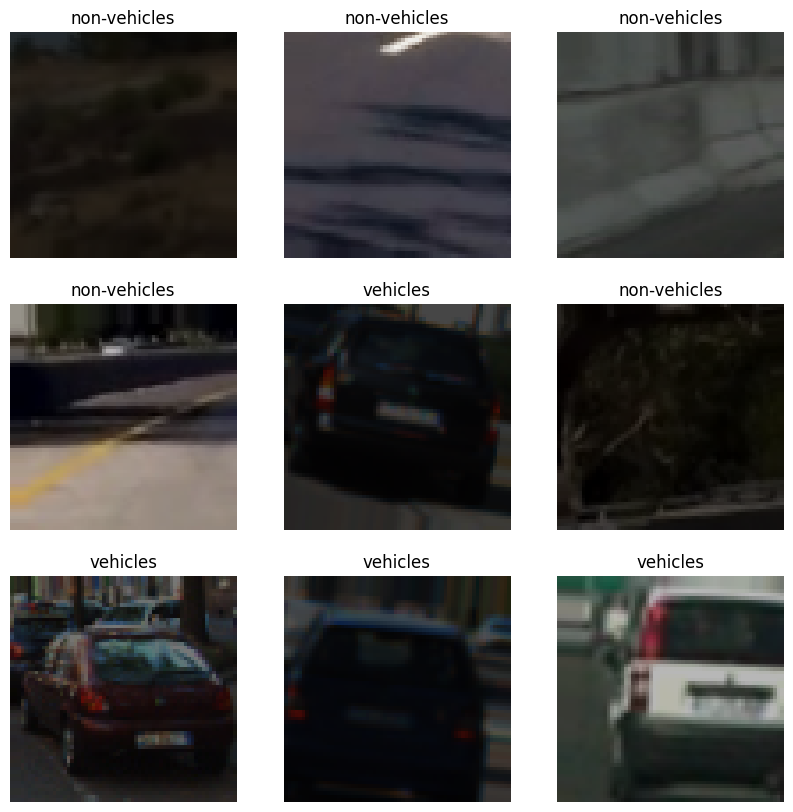

In [6]:

# Plot some images from the training dataset
import matplotlib.pyplot as plt

batch = next(train_dataset)
images = batch[0]
labels = batch[1]
class_names = list(train_dataset.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.show()

# **CallBack Function**

In [7]:
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)

# **MobileNet Transfer Learning CNN Model**

In [8]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

base_model = MobileNet(include_top=False, 
                   weights='imagenet', 
                   input_shape=(64, 64, 3))
base_model.trainable = True
# Create a new model by adding new layers on top of the VGG16 base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


17225924/17225924 [==============================] - 0s 0us/step


In [9]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    batch_size=32,
    callbacks=[early_stop],
)

Epoch 1/25
406/406 [==============================] - 64s 80ms/step - loss: 0.0662 - accuracy: 0.9780 - val_loss: 0.0545 - val_accuracy: 0.9867
Epoch 2/25
406/406 [==============================] - 33s 81ms/step - loss: 0.0331 - accuracy: 0.9903 - val_loss: 0.0268 - val_accuracy: 0.9896
Epoch 3/25
406/406 [==============================] - 31s 76ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0570 - val_accuracy: 0.9807
Epoch 4/25
406/406 [==============================] - 32s 78ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0301 - val_accuracy: 0.9926
Epoch 5/25
406/406 [==============================] - 32s 78ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.1011 - val_accuracy: 0.9615
Epoch 6/25
406/406 [==============================] - 33s 81ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0234 - val_accuracy: 0.9886
Epoch 7/25
406/406 [==============================] - 31s 77ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0129 - val_accuracy:

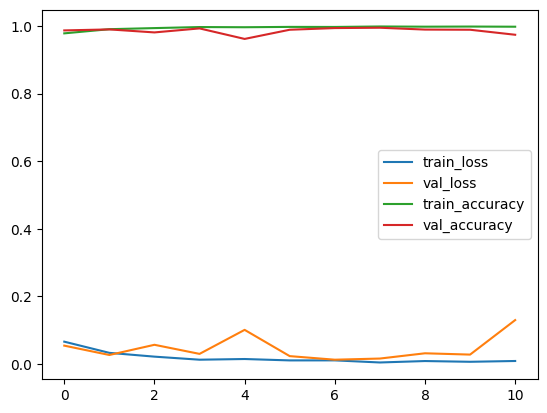

In [11]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# **Performance Test**

87/87 [==============================] - 2s 28ms/step - loss: 0.0848 - accuracy: 0.9826


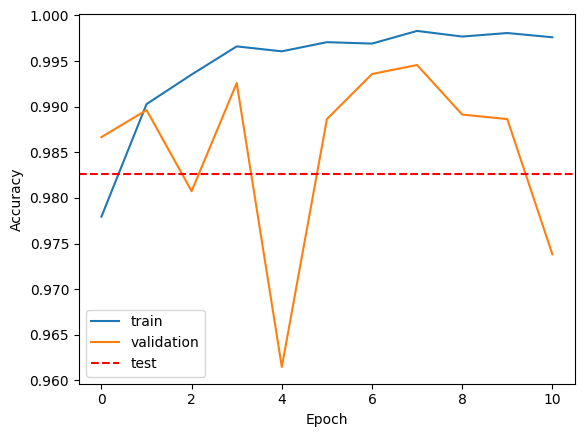

In [12]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

# Plot the performance
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.axhline(y=test_acc, color='r', linestyle='--', label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Testing by UserInput Image**

Saving scorpio-classic-exterior-left-front-three-quarter.jpg to scorpio-classic-exterior-left-front-three-quarter.jpg


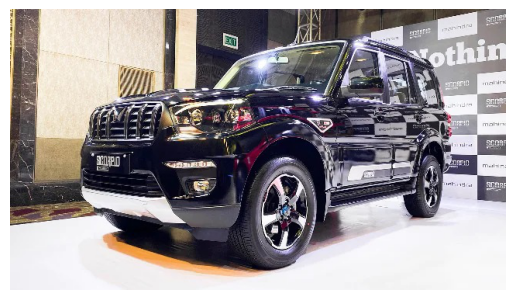

1/1 [==============================] - 1s 659ms/step
Vehicle detected in the image!


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Define a function to preprocess the image
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.
  return x

# Define a function to predict whether there's a vehicle in the image or not
def predict_vehicle(img_path):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  x = preprocess_image(img_path)
  prediction = model.predict(x)
  if prediction[0][0] != 1:
    print("Vehicle detected in the image!")
  else:
    print("No vehicle detected in the image.")

# Allow the user to upload an image
from google.colab import files
uploaded = files.upload()

# Call the predict_vehicle function for the uploaded image
for fn in uploaded.keys():
  path = fn
  predict_vehicle(path)
